# Yelp Business Reviews - Sentiment Analysis

## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, length, lit, lower, regexp_replace, size, split, filter, udf, sum, when
from pyspark.sql.types import ArrayType,StringType, FloatType, StructType, StructField

from pyspark.ml.feature import CountVectorizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import Vector
from pyspark.ml.functions import vector_to_array

## Creating Spark Environment

In [ ]:
# UNCOMMENT WHEN RUNNING LOCALLY 

""" 
# Create a spark session
findspark.init()
spark = SparkSession.builder \
    .appName("Yelp_Sentiment_Analysis") \
    .master("local[8]") \
    .config("spark.executor.memory", "10g") \
    .config("spark.executor.cores", "3") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

### Patlarsa dene
#.config("spark.memory.offHeap.enabled","true") 
#.config("spark.memory.offHeap.size","10g")
"""

In [ ]:
# Get config
conf = spark.sparkContext.getConf()

# Print the configuration settings
print("spark.app.name = ", conf.get("spark.app.name"))
print("spark.master = ", conf.get("spark.master"))
print("spark.executor.memory = ", conf.get("spark.executor.memory"))
print("spark.executor.cores = ", conf.get("spark.executor.cores")),
print("spark.driver.memory = ", conf.get("spark.driver.memory"))
print("spark.rpc.message.maxSize = ", conf.get("spark.rpc.message.maxSize"))
print("spark.kryoserializer.buffer.max = ", conf.get("spark.kryoserializer.buffer.max"))

In [ ]:
# UNCOMMENT WHEN RUNNING LOCALLY 

"""
# Source file pathways on local disk
path_business = "../yelp_academic_dataset_business.json"
path_review = "../yelp_academic_dataset_review.json"
positive_path = "../positive_words.txt"
negative_path = "../negative_words.txt"
"""

In [ ]:
# Source file pathways on ABFSS
path_business = "abfss://unity-catalog-storage@dbstoragepwtbcgut4qtn6.dfs.core.windows.net/yelp_academic_dataset_business.json"
path_review = "abfss://unity-catalog-storage@dbstoragepwtbcgut4qtn6.dfs.core.windows.net/yelp_academic_dataset_review.json"
positive_path = "abfss://unity-catalog-storage@dbstoragepwtbcgut4qtn6.dfs.core.windows.net/positive_words.txt"
negative_path = "abfss://unity-catalog-storage@dbstoragepwtbcgut4qtn6.dfs.core.windows.net/negative_words.txt"

## Data Preprocessing

### I. Cleaning of 'Business' Dataset

In [ ]:
# Import business data
business = spark.read.json(path_business)

In [244]:
# Print first 10 rows
business.show(n=10, truncate=10)

StatementMeta(sparkpool, 44, 11, Finished, Available)

+----------+----------+-----------+----------+----------+----------+-------+----------+----------+----------+-----------+------------+-----+-----+
|   address|attributes|business_id|categories|      city|     hours|is_open|  latitude| longitude|      name|postal_code|review_count|stars|state|
+----------+----------+-----------+----------+----------+----------+-------+----------+----------+----------+-----------+------------+-----+-----+
|1616 Ch...|{null, ...| Pns2l4e...|Doctors...|Santa B...|      null|      0|34.4266787|-119.71...|Abby Ra...|      93101|           7|  5.0|   CA|
|87 Gras...|{null, ...| mpf3x-B...|Shippin...|    Affton|{8:0-18...|      1| 38.551126|-90.335695|The UPS...|      63123|          15|  3.0|   MO|
|5255 E ...|{null, ...| tUFrWir...|Departm...|    Tucson|{8:0-23...|      0| 32.223236|-110.88...|    Target|      85711|          22|  3.5|   AZ|
|935 Rac...|{null, ...| MTSW4Mc...|Restaur...|Philade...|{7:0-21...|      1|39.9555052|-75.155...|St Hono...|      191

In [ ]:
# Drop irrelevant columns
business = business.drop('attributes','hours')

In [246]:
# Print current dataset schema
business.printSchema()

StatementMeta(sparkpool, 44, 13, Finished, Available)

root
 |-- address: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- city: string (nullable = true)
 |-- is_open: long (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- name: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- stars: double (nullable = true)
 |-- state: string (nullable = true)



In [ ]:
# Filter out rows with null 'categories'
business = business.filter(col("categories").isNotNull())

In [ ]:
# Filter for businesses in US states
states = [ "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS",\
 "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY", ]
 
usa = business.filter(col("state").isin(states))

In [249]:
# Print out the total number of businesses in dataset
print(f"Number of US businesses in the dataset: {usa.count()}")

StatementMeta(sparkpool, 44, 16, Finished, Available)

Number of US businesses in the dataset: 144669


In [250]:
# Filter restaurants
us_restaurants = usa.filter(usa["categories"].contains("Restaurants"))

# Print out the number of total US restaurants
print(f"Number of total US restaurants in the dataset: {us_restaurants.count()}")

StatementMeta(sparkpool, 44, 17, Finished, Available)

Number of total US restaurants in the dataset: 49857


In [ ]:
# Label every row with their type of cuisine
us_restaurants = us_restaurants.withColumn(
    "category",
    when(col("categories").contains("Korean"), "Korean")
    .when(col("categories").contains("Thai"), "Thai")
    .when(col("categories").contains("French"), "French")
    .when(col("categories").contains("Greek"), "Greek")
    .when(col("categories").contains("Indian"), "Indian")
    .when(col("categories").contains("Hawaiian"), "Hawaiian")
    .when(col("categories").contains("African"), "African")
    .when(col("categories").contains("Spanish"), "Spanish")
)

In [ ]:
# Drop the old category column
us_restaurants = us_restaurants.drop("categories")

# Filter out null categories
us_restaurants = us_restaurants.filter(col("category").isNotNull())

In [253]:
# Print out the total number of restaurants that are labeled by their cuisine types
print(f"Number of labeled US restaurants in the dataset: {us_restaurants.count()}")

StatementMeta(sparkpool, 44, 20, Finished, Available)

Number of labeled US restaurants in the dataset: 3819


In [254]:
# Check if the dataset contains any duplicated businesses
us_restaurants.groupBy("business_id").count().filter(col("count") > 1).count()

StatementMeta(sparkpool, 44, 21, Finished, Available)

0

In [255]:
# Show us_restaurants after cleaning
us_restaurants.show(5)

StatementMeta(sparkpool, 44, 22, Finished, Available)

+--------------------+--------------------+---------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+--------+
|             address|         business_id|           city|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|category|
+--------------------+--------------------+---------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+--------+
|   8025 Mackenzie Rd|k0hlBqXX-Bt0vf1op...|         Affton|      0|   38.5651648|   -90.3210868|Tsevi's Pub And G...|      63123|          19|  3.0|   MO|   Greek|
|       1224 South St|ROeacJQwBeh05Rqg7...|   Philadelphia|      1|    39.943223|    -75.162568|                 BAP|      19147|         205|  4.5|   PA|  Korean|
|       163 107th Ave|vje0KIiE7vtpx7Jzm...|Treasure Island|      1|   27.7694046|    -82.767317|           The Pearl|      33706|         129|  4.0|   FL|  French|
|2E Summit Sq Sh

### II. Cleaning of 'Review' Dataset

In [ ]:
# Import review data
review = spark.read.json(path_review)

In [257]:
# Print first 10 rows
review.show(n=10, truncate=20)

StatementMeta(sparkpool, 44, 24, Finished, Available)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:54:15|    0|Sx8TMOWLNuJBWer-0...|  4.0|Cute inter

In [ ]:
# Select relevant columns
review = review.select('business_id','text','stars')

In [259]:
# Print current dataset schema
review.printSchema()

StatementMeta(sparkpool, 44, 26, Finished, Available)

root
 |-- business_id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- stars: double (nullable = true)



### III. Joining Datasets

In [ ]:
# Change the names of 'stars' columns in both datasets to avoid confusion
us_restaurants = us_restaurants.withColumnRenamed("stars", "avg_star")
review = review.withColumnRenamed("stars", "review_star")

In [ ]:
# Join the dataframes on 'business_id'
restaurants_reviews = us_restaurants.join(review, on="business_id", how="inner")

In [262]:
# Print the schema of merged dataframe
restaurants_reviews.printSchema()

StatementMeta(sparkpool, 44, 29, Finished, Available)

root
 |-- business_id: string (nullable = true)
 |-- address: string (nullable = true)
 |-- city: string (nullable = true)
 |-- is_open: long (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- name: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- avg_star: double (nullable = true)
 |-- state: string (nullable = true)
 |-- category: string (nullable = true)
 |-- text: string (nullable = true)
 |-- review_star: double (nullable = true)



### IV. Feature Extraction

In [ ]:
# Create a 'labels' column
# 4-5 Stars --> Positive
# 3 Stars --> Neutral
# 1-2 Stars --> Negative

restaurants_reviews = restaurants_reviews.withColumn(
    "labels",
    when(restaurants_reviews["review_star"] >= 4, "positive")
    .when(restaurants_reviews["review_star"] == 3, "neutral")
    .when(restaurants_reviews["review_star"] < 3, "negative"),
)

In [264]:
# Filter out neutral reviews
restaurants_reviews = restaurants_reviews.where(
    restaurants_reviews["labels"] != "neutral")

# Count total number of positive and negative reviews

print(f'The number of positive and negative reviews : {restaurants_reviews.count()}')

StatementMeta(sparkpool, 44, 31, Finished, Available)

The number of positive and negative reviews : 419726


In [ ]:
# Convert 'labels' column to boolean
restaurants_reviews = restaurants_reviews.withColumn('labels_bool', when(col('labels') == 'positive' , 1).otherwise(0))

In [265]:
# Show the distribution of reviews by category
restaurants_reviews.groupBy('category').count().sort('count',ascending = False).show()

StatementMeta(sparkpool, 44, 32, Finished, Available)

+--------+-----+
|category|count|
+--------+-----+
|    Thai|99373|
|  French|81571|
|  Indian|66369|
|   Greek|63339|
|  Korean|48354|
| Spanish|33161|
|Hawaiian|21394|
| African| 6165|
+--------+-----+



### V. Text Processing

In [266]:
# Show 'text' column before processing
restaurants_reviews.select("text").show(10, truncate=80)

StatementMeta(sparkpool, 44, 33, Finished, Available)

+--------------------------------------------------------------------------------+
|                                                                            text|
+--------------------------------------------------------------------------------+
|Wow!  Yummy, different,  delicious.   Our favorite is the lamb curry and korm...|
|I am a long term frequent customer of this establishment. I just went in to o...|
|I was really between 3 and 4 stars for this one. I LOVE the 96th street Naked...|
|Best thai food in the area.  Everything was authentic and delicious.  Will de...|
|It was my fiance's birthday and he decided he wanted a good, laid back Thai r...|
|My go to menu is coconut soup and pad thai with protein. I tried same menu he...|
|Been here so many times before and all I can say is the food is really good. ...|
|This is the first time I tried this place and  I was surprisingly surprised. ...|
|I must admit, I wasn't expecting much. This place totally blew us away. This ...|
|We 

#### a. Text Cleaning

In [ ]:
# Convert 'text' to lowercase
restaurants_reviews = restaurants_reviews.withColumn("text", F.lower(F.col("text")))

In [ ]:
# Transform review text by using regular expressions

# Replace all non-alphanumeric characters with a whitespace.
restaurants_reviews = restaurants_reviews.withColumn(
    "text_clean", F.regexp_replace(F.col("text"), "[^a-zA-Z0-9\s]", " ")
)

# Replace all line break character with a whitespace.
restaurants_reviews = restaurants_reviews.withColumn(
    "text_clean", F.regexp_replace(F.col("text_clean"), "\n", " ")
)

# Replace all consecutive whitespaces with a single whitespace.
restaurants_reviews = restaurants_reviews.withColumn(
    "text_clean", F.regexp_replace(F.col("text_clean"), "\\s+", " ")
)

# Delete all whitespace characters at the end of each string.
restaurants_reviews = restaurants_reviews.withColumn(
    "text_clean", F.regexp_replace(F.col("text_clean"), "\s+$", "")
)

In [269]:
# Show 'text_clean' column after transformation
restaurants_reviews.select("text_clean").show(10, truncate=50)

StatementMeta(sparkpool, 44, 36, Finished, Available)

+--------------------------------------------------+
|                                        text_clean|
+--------------------------------------------------+
|wow yummy different delicious our favorite is t...|
|i am a long term frequent customer of this esta...|
|i was really between 3 and 4 stars for this one...|
|best thai food in the area everything was authe...|
|it was my fiance s birthday and he decided he w...|
|my go to menu is coconut soup and pad thai with...|
|been here so many times before and all i can sa...|
|this is the first time i tried this place and i...|
|i must admit i wasn t expecting much this place...|
|we have been here twice for brunch and have enj...|
+--------------------------------------------------+
only showing top 10 rows



#### b. Stopword Removal

In [272]:
# There are 2 .txt files in the main directory where positive and negative words in English language are collected.
# Mentioned text files will be used to evaluate whether a word is positive or negative.

# Read text files and create RDDs
positive_rdd = spark.sparkContext.textFile(positive_path)
negative_rdd = spark.sparkContext.textFile(negative_path)

# Convert RDDs into lists
positive_words = positive_rdd.collect()
negative_words = negative_rdd.collect()

# Create lists with useless words that doesn't give any valuable info about restaurants.
positive_useless = [ "great", "amazing", "love", "best", "awesome", "excellent", "good", "favorite", "loved", "perfect", "gem", "perfectly",
"wonderful", "happy", "enjoyed", "nice", "well", "super", "like", "better", "decent", "fine", "pretty", "enough", "excited", "impressed", 
"ready", "fantastic", "glad", "right", "fabulous", ]
negative_useless = [ "bad", "disappointed", "unfortunately", "disappointing", "horrible", "lacking", "terrible", "sorry", "disappoint", "worst", ]

# Filter useless words out
positive_words = [x for x in positive_words if x not in positive_useless]
negative_words = [x for x in negative_words if x not in negative_useless]

# Print first 10 elements of lists
print(positive_words[:10])
print(negative_words[:10])

StatementMeta(sparkpool, 44, 39, Finished, Available)

['abound', 'abounds', 'abundance', 'abundant', 'accessable', 'accessible', 'acclaim', 'acclaimed', 'acclamation', 'accolade']
['abnormal', 'abolish', 'abominable', 'abominably', 'abominate', 'abomination', 'abort', 'aborted', 'aborts', 'abrade']


#### c. Tokenization

In [ ]:
def filter_words(col):
    """ Splits text into a list of strings and filter out the words that are not in positive or negative word list."""
    
    text = [i for i in col.split() if i in positive_words + negative_words]
    return text

In [ ]:
# Create a user-defined function (UDF) and filter text column
restaurants_reviews = restaurants_reviews.withColumn("text_filtered", udf(filter_words, returnType=ArrayType(StringType()))(col("text_clean")))

In [ ]:
#Drop unnecessary columns
restaurants_reviews = restaurants_reviews.select(['category','text_filtered','labels_bool'])

In [277]:
#Print the schema
restaurants_reviews.printSchema()

StatementMeta(sparkpool, 44, 44, Finished, Available)

root
 |-- category: string (nullable = true)
 |-- text_filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- labels_bool: integer (nullable = false)



In [278]:
# Print the dataframe
restaurants_reviews.show(3)

StatementMeta(sparkpool, 44, 45, Finished, Available)

+--------+--------------------+-----------+
|category|       text_filtered|labels_bool|
+--------+--------------------+-----------+
|  Indian|[wow, delicious, ...|          1|
|   Greek|        [dick, fuck]|          0|
|Hawaiian|[consistently, sl...|          1|
+--------+--------------------+-----------+
only showing top 3 rows



In [281]:
# Print the row number of dataframe
restaurants_reviews.count()

StatementMeta(sparkpool, 44, 48, Finished, Available)

419726

## Implementing Bag-of-Words

After this point, all the processes will be implemented for 'African' restaurants.

In [ ]:
# Define a function that filters rows based on the 'category' parameter
def get_dataset(category):
    """Takes in a category name as string. Returns a DataFrame with filtered rows based on category argument."""

    # Filter DataFrame to only include reviews for the given category
    df = restaurants_reviews.filter(col("category") == category)

    # Select relevant columns
    df = df.select(["text_filtered","labels_bool"])

    return df

In [ ]:
# Get the dataframe for African restaurants
African = get_dataset("African")

In [311]:
# Display data types
African.dtypes

StatementMeta(sparkpool, 20, 43, Finished, Available)

[('text_filtered', 'array<string>'), ('labels_bool', 'int')]

### I. Building Vocabulary

In [ ]:
# Create a CountVectorizer object
vectorizer = CountVectorizer(inputCol = 'text_filtered', outputCol = 'vector')

# Fit the CountVectorizer object to the dataset
vectorizer_model = vectorizer.fit(African)

In [27]:
# Get word list learnt by 'vectorizer_model'
vocab = vectorizer_model.vocabulary

#Print out the first 10 element of the list
vocab[:10]

StatementMeta(sparkpool, 17, 28, Finished, Available)

['delicious',
 'friendly',
 'recommend',
 'fried',
 'fresh',
 'sweet',
 'worth',
 'hot',
 'enjoy',
 'beautiful']

### II. Vectorization

In [ ]:
# Transform the dataframe to get sparse vectors based on 'text_filtered' column
African_df = vectorizer_model.transform(African)

In [31]:
# Show the first 5 rows 
African_df.show(5,truncate = 80)

StatementMeta(sparkpool, 16, 32, Finished, Available)

+--------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+-----------+
|  labels|                                                                   text_filtered|                                                                          vector|labels_bool|
+--------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+-----------+
|positive|                                                                      [friendly]|                                                                (1973,[1],[1.0])|          1|
|positive|                                                                         [rusty]|                                                               (1973,[24],[1.0])|          1|
|positive|[fresh, dedicated, gained, enjoy, enjoy, beautiful, awful, cozy, 

### III. Deriving Weights

In [ ]:
# Create a LogisticRegression object
lr = LogisticRegression(featuresCol = 'vector', labelCol = 'labels_bool')

# Fit the dataframe into object to create a LogisticRegressionModel object
lr_model = lr.fit(African_df)

In [31]:
# Extract coefficients from LR model
coeff = lr_model.coefficients

# Convert coeficients to float dtype
coeff = [float(i) for i in coeff]

# Display first 10 elements
coeff[:10]

StatementMeta(sparkpool, 17, 32, Finished, Available)

[3.5142131519065587,
 1.6145403134708656,
 1.1109860864823224,
 0.1576573331590272,
 0.6378908147176446,
 0.6598956823469534,
 0.4010368793251726,
 0.8482240452829103,
 -0.3834754860223588,
 0.02819239682736559]

In [32]:
# Zip the vocabulary and coefficient into a list of tuples
word_coeff = [(i,j) for (i,j) in zip(vocab,coeff)]

# Display the first 5 elements
word_coeff[:5]

StatementMeta(sparkpool, 17, 33, Finished, Available)

[('delicious', 3.5142131519065587),
 ('friendly', 1.6145403134708656),
 ('recommend', 1.1109860864823224),
 ('fried', 0.1576573331590272),
 ('fresh', 0.6378908147176446)]

In [33]:
# Create a new dataframe contains vocabulary and their coefficients
word_coeff_df = spark.createDataFrame(word_coeff,['word','coeff'])

# Show the first 5 rows
word_coeff_df.show(5)

StatementMeta(sparkpool, 17, 34, Finished, Available)

+---------+------------------+
|     word|             coeff|
+---------+------------------+
|delicious|3.5142131519065587|
| friendly|1.6145403134708656|
|recommend|1.1109860864823224|
|    fried|0.1576573331590272|
|    fresh|0.6378908147176446|
+---------+------------------+
only showing top 5 rows



### IV. Creating the Bag-of-Words Matrix

In [34]:
# Select 'vector' column and display first 5 rows
African_df.select('vector').show(5, truncate = 100)

StatementMeta(sparkpool, 17, 35, Finished, Available)

+----------------------------------------------------------------------------------------+
|                                                                                  vector|
+----------------------------------------------------------------------------------------+
|                                                                        (1973,[1],[1.0])|
|                                                                       (1973,[24],[1.0])|
|(1973,[4,6,8,9,53,58,69,80,832,1658,1720],[1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|                 (1973,[6,17,18,135,143,166,186,1757],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|                                         (1973,[0,14,120,261,737],[1.0,1.0,1.0,1.0,1.0])|
+----------------------------------------------------------------------------------------+
only showing top 5 rows



In [ ]:
# Convert sparse vector to dense array
vector_dense_arr = vector_to_array(African_df.vector)

# Add 'vector_dense' column to the dataframe
African_df = African_df.withColumn('vector_dense',vector_dense_arr)

In [36]:
# Show the first 5 rows
African_df.show(5)

StatementMeta(sparkpool, 17, 37, Finished, Available)

+--------+--------------------+--------------------+-----------+--------------------+
|  labels|       text_filtered|              vector|labels_bool|    vector_dense_arr|
+--------+--------------------+--------------------+-----------+--------------------+
|positive|          [friendly]|    (1973,[1],[1.0])|          1|[0.0, 1.0, 0.0, 0...|
|positive|             [rusty]|   (1973,[24],[1.0])|          1|[0.0, 0.0, 0.0, 0...|
|positive|[fresh, dedicated...|(1973,[4,6,8,9,53...|          1|[0.0, 0.0, 0.0, 0...|
|positive|[lost, beautifull...|(1973,[6,17,18,13...|          1|[0.0, 0.0, 0.0, 0...|
|positive|[top, delicious, ...|(1973,[0,14,120,2...|          1|[1.0, 0.0, 0.0, 0...|
+--------+--------------------+--------------------+-----------+--------------------+
only showing top 5 rows



In [37]:
# Create an RDD from dataframe's 'vector_dense_arr' column
vector_dense_rdd = African_df.select('vector_dense_arr').rdd

# Convert RDD to list
c = vector_dense_rdd.collect()

# Print the type of 'c'
type(c)

StatementMeta(sparkpool, 17, 38, Finished, Available)

list

In [ ]:
# Convert c from a list of Row objects to a list of Float
c = list(map(lambda x: x[0],c))

In [40]:
# Define a StructType object to use as schema
schema = StructType(
[StructField(i,FloatType(),False) for i in vocab]
)

# Print the first 10 elements of the schema
schema[:10]

StatementMeta(sparkpool, 17, 41, Finished, Available)

StructType([StructField('delicious', FloatType(), False), StructField('friendly', FloatType(), False), StructField('recommend', FloatType(), False), StructField('fried', FloatType(), False), StructField('fresh', FloatType(), False), StructField('sweet', FloatType(), False), StructField('worth', FloatType(), False), StructField('hot', FloatType(), False), StructField('enjoy', FloatType(), False), StructField('beautiful', FloatType(), False)])

In [ ]:
# Create a Spark Dataframe, using StructType as schema parameter
matrix = spark.createDataFrame(c,schema = schema)

In [43]:
# Convert Spark DataFrame to Pandas DataFrame
matrix_pd = matrix.toPandas()

# Show the first 3 rows
matrix_pd.head(3)

StatementMeta(sparkpool, 17, 44, Finished, Available)

,delicious,friendly,recommend,fried,fresh,sweet,worth,hot,enjoy,beautiful,...,accurately,agonizingly,offender,massacre,trusty,favour,outraged,deterrent,achievement,beloved
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### V. Counting Frequencies

In [ ]:
# Count the total number of occurrence for every word
frequency = matrix_pd.sum(axis = 0)

In [45]:
# Print the pd series
frequency

StatementMeta(sparkpool, 17, 46, Finished, Available)

delicious      1514.0
friendly        925.0
recommend       766.0
fried           657.0
fresh           592.0
                ...  
favour            1.0
outraged          1.0
deterrent         1.0
achievement       1.0
beloved           1.0
Length: 1973, dtype: float32

In [ ]:
# Convert pd series to RDD
freq_rdd = sc.parallelize(frequency)

In [ ]:
# Convert RDD to list
freq = freq_rdd.collect()

In [48]:
# Display first 10 elements of the list
display(freq[:10])

#Print the type of 'freq' variable
type(freq)

StatementMeta(sparkpool, 17, 49, Finished, Available)

[1514.0, 925.0, 766.0, 657.0, 592.0, 501.0, 454.0, 446.0, 296.0, 295.0]

list

In [ ]:
# Zip three variables and create a list of three tuples
word_coeff_freq = [(i,j,k) for (i,j,k) in zip(vocab,coeff,freq)]

In [50]:
# Print the first 10 elements of the list
word_coeff_freq[:10]

StatementMeta(sparkpool, 17, 51, Finished, Available)

[('delicious', 3.5142131519065587, 1514.0),
 ('friendly', 1.6145403134708656, 925.0),
 ('recommend', 1.1109860864823224, 766.0),
 ('fried', 0.1576573331590272, 657.0),
 ('fresh', 0.6378908147176446, 592.0),
 ('sweet', 0.6598956823469534, 501.0),
 ('worth', 0.4010368793251726, 454.0),
 ('hot', 0.8482240452829103, 446.0),
 ('enjoy', -0.3834754860223588, 296.0),
 ('beautiful', 0.02819239682736559, 295.0)]

In [ ]:
# Create a Spark DataFrame from the list of tuples
word_coeff_freq_df = spark.createDataFrame(word_coeff_freq, ['word','coeff','freq'])

In [52]:
# Show first 10 rows
word_coeff_freq_df.show(10)

StatementMeta(sparkpool, 17, 53, Finished, Available)

+---------+-------------------+------+
|     word|              coeff|  freq|
+---------+-------------------+------+
|delicious| 3.5142131519065587|1514.0|
| friendly| 1.6145403134708656| 925.0|
|recommend| 1.1109860864823224| 766.0|
|    fried| 0.1576573331590272| 657.0|
|    fresh| 0.6378908147176446| 592.0|
|    sweet| 0.6598956823469534| 501.0|
|    worth| 0.4010368793251726| 454.0|
|      hot| 0.8482240452829103| 446.0|
|    enjoy|-0.3834754860223588| 296.0|
|beautiful|0.02819239682736559| 295.0|
+---------+-------------------+------+
only showing top 10 rows



### VI. Calculating Polarities

In [ ]:
# Total number of reviews for the given category ('African', in this instance.)
n = matrix.count()

In [ ]:
# Polarity = (Coefficient * Frequency) / (Total number of reviews)
# Calculate polarity and create new column
African_master_df = word_coeff_freq_df.withColumn('polarity', col('coeff') * col('freq') / n)

## Creating the Polarity Table

In [55]:
# Show the top 10 negative words
African_master_df.sort('polarity',ascending = True).show(10)

StatementMeta(sparkpool, 17, 56, Finished, Available)

+----------+-------------------+-----+--------------------+
|      word|              coeff| freq|            polarity|
+----------+-------------------+-----+--------------------+
|disgusting|  -18.4423288011563| 52.0|  -0.155555733602616|
|     worse|-15.350032117209746| 51.0|-0.12698323405964268|
|     gross|-18.299362377860998| 42.0|-0.12466718894893138|
|    refund|-30.264265516607576| 23.0|-0.11290804653397798|
|ridiculous|-21.297797459989937| 32.0|-0.11054817821892587|
|     trash| -17.52243916931295| 34.0|-0.09663632307488083|
|      hell|-23.551262435959178| 24.0|-0.09168374670933013|
|      cold| -2.120295824857995|263.0|-0.09045219820562087|
|      poor| -6.326108254527946| 87.0|-0.08927354714418999|
|      rude| -4.223422461511341|125.0|-0.08563305883031917|
+----------+-------------------+-----+--------------------+
only showing top 10 rows



In [56]:
# Show the top 10 positive words
African_master_df.sort('polarity',ascending = False).show(10)

StatementMeta(sparkpool, 17, 57, Finished, Available)

+-----------+------------------+------+-------------------+
|       word|             coeff|  freq|           polarity|
+-----------+------------------+------+-------------------+
|  delicious|3.5142131519065587|1514.0| 0.8630200668266876|
|   friendly|1.6145403134708656| 925.0|0.24224651905280625|
| phenomenal|14.140373586371757|  79.0|0.18119862341011658|
|   romantic| 34.29621583873816|  26.0|0.14463935309119094|
|  recommend|1.1109860864823224| 766.0|0.13803979598466487|
|   enjoying|14.766156209598272|  51.0|0.12215311706237013|
|outstanding| 8.706570076182462|  84.0|0.11862966527158587|
| perfection|  7.13990960960451|  95.0|0.11002293802310274|
| delightful|14.429629055613333|  45.0|0.10532575953002432|
|   generous| 5.320731894915049| 112.0|0.09666212039423934|
+-----------+------------------+------+-------------------+
only showing top 10 rows



In [ ]:
# Subset dataframes to get top and bottom 10 rows
African_positive_10 = African_master_df.sort('polarity',ascending = False).head(10)
African_negative_10 = African_master_df.sort('polarity',ascending = True).head(10)

In [ ]:
# Creating pd DataFrames
African_positive_10_pd = pd.DataFrame(African_positive_10, columns = African_master_df.columns)
African_negative_10_pd = pd.DataFrame(African_negative_10, columns = African_master_df.columns)

In [ ]:
# Sort negative words in descending order
African_negative_10_pd = African_negative_10_pd.sort_values('polarity',ascending = False)

In [125]:
# Concatenate posiitve and negative words
African_concat = pd.concat([African_positive_10_pd,African_negative_10_pd])

# Print the polarity table
African_concat.head(20)

StatementMeta(sparkpool, 17, 126, Finished, Available)

,word,coeff,freq,polarity
0,delicious,3.514213,1514.0,0.863020
1,friendly,1.614540,925.0,0.242247
2,phenomenal,14.140374,79.0,0.181199
3,romantic,34.296216,26.0,0.144639
4,recommend,1.110986,766.0,0.138040
5,enjoying,14.766156,51.0,0.122153
6,outstanding,8.706570,84.0,0.118630
7,perfection,7.139910,95.0,0.110023
8,delightful,14.429629,45.0,0.105326
9,generous,5.320732,112.0,0.096662


## Generating the Plot

StatementMeta(sparkpool, 17, 153, Finished, Available)

<Figure size 640x480 with 0 Axes>

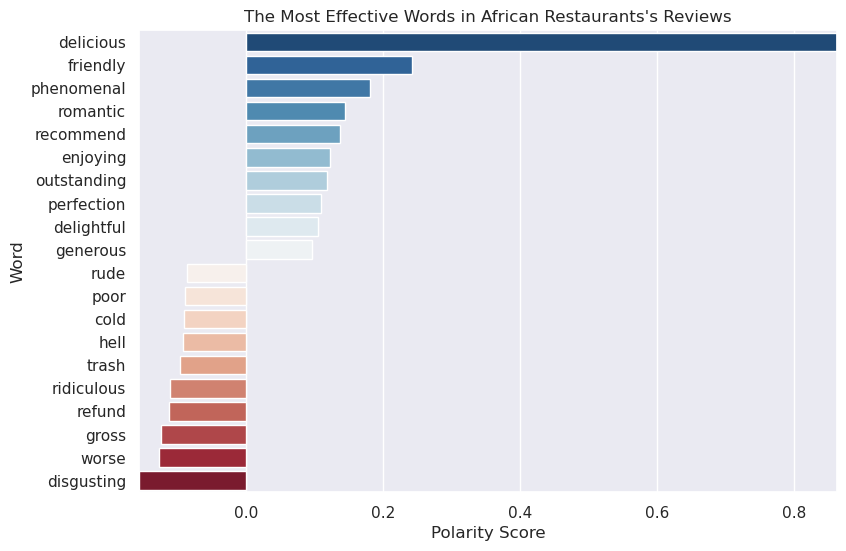

In [152]:
# Set 'darkgrid' style
sns.set_style('darkgrid')
# Set 'notebook' context for better readability
sns.set_context('notebook')
# Create a figure and an axis object of 9x6 size
fig,ax = plt.subplots(figsize = (9,6))
# Create a bar plot, 'polarity' on x axis and 'word' on y axis
#Use a diverging palette for a better narrative impact
sns.barplot(data = African_concat, x = 'polarity' , y = 'word', palette = 'RdBu_r')
# Set the title of the plot
plt.title("The Most Effective Words in African Restaurants's Reviews")
# Set labels for x and y axis.
plt.xlabel('Polarity Score')
plt.ylabel('Word')
# Set the x-axis limits to the min and max values of the 'polarity' column
plt.xlim(African_concat['polarity'].min(),African_concat['polarity'].max())
# Show the plot
plt.show()

## Function Definitions

In [ ]:
def get_polarity(category):
    """
    Calculate polarity scores for a given category.

    Args:
    - category (str): Category of the restaurants to filter data.

    Returns:
    - DataFrame: DataFrame containing the top 10 positive and negative polarity words.
    """
    
    # Filter the df and get relevant columns
    df = restaurants_reviews.filter(col("category") == category)
    df = df.select(['text_filtered','labels_bool'])

    # Building vocabulary
    vectorizer = CountVectorizer(inputCol = 'text_filtered', outputCol = 'vector')
    vectorizer_model = vectorizer.fit(df)
    vocab = vectorizer_model.vocabulary
    
    # Vectorization
    df = vectorizer_model.transform()

    # Deriving weights
    lr = LogisticRegression(featuresCol = 'vector', labelCol = 'labels_bool')
    lr_model = lr.fit(df)
    coeff = lr_model.coefficients
    coeff = [float(i) fo]
    
    # Creating the bag-of-words matrix
    vector_dense_arr = vector_to_array(df.vector)
    df = df.withColumn('vector_dense',vector_dense_arr)
    vector_dense_rdd = df.select('vector_dense').rdd
    vec = vector_dense_rdd.collect()
    vec = list(map(lambda x: x[0],vec))
    schema = StructType(
    [StructField(i,FloatType(),False) for i in vocab]
    )
    matrix = spark.createDataFrame(vec,schema = schema)
    matrix_pd = matrix.toPandas()
    
    # Counting frequencies
    freq_series = matrix_pd.sum(axis = 0)
    freq_rdd = sc.parallelize(freq_series)
    freq = freq_rdd.collect()
    word_coeff_freq = [(i,j,k) for (i,j,k) in zip(vocab,coeff,freq)]
    word_coeff_freq_df = spark.createDataFrame(word_coeff_freq, ['word','coeff','freq'])
    
    # Calculating polarities
    n = matrix.count()
    master_df = word_coeff_freq_df.withColumn('polarity', col('coeff') * col('freq') / n)
    
    # Creating the polarity table
    positive_10 = master_df.sort('polarity',ascending = False).head(10)
    negative_10 = master_df.sort('polarity',ascending = True).head(10)
    positive_10_pd = pd.DataFrame(positive_10, columns = master_df.columns)
    negative_10_pd = pd.DataFrame(negative_10, columns = master_df.columns)
    negative_10_pd = negative_10_pd.('polarity',ascending = False)
    sum_df =positive_10_pd,negative_10_pd])
    
    # Return the df
    return sum_df

In [ ]:
def get_plot(sum_df,category):
        """
    Generate a bar plot showing the most effective words in restaurant reviews for a given category.

    Args:
    - sum_df (DataFrame): DataFrame containing polarity scores and words.
    - category (str): Category of the restaurants.
    """
    # Set style and context
    sns.set_style('darkgrid')
    sns.set_context('notebook')

    # Create a figure and axis object
    fig,ax = plt.subplots(figsize = (9,6))

    # Create the plot
    sns.barplot(data = sum_df, x = 'polarity' , y = 'word',palette = 'RdBu_r')
    
    # Set the title and labels on both axis
    plt.title("The Most Effective Words in " + category + " Restaurants's Reviews")
    plt.xlabel('Polarity Score')
    plt.ylabel('Word')

    # Set minimum and maximum limits on x-axis
    plt.xlim(sum_df['polarity'].min(),sum_df['polarity'].max())

    # Display the plot
    plt.show()

## Implementation and Results

In [ ]:
african_df = get_polarity('African')

In [363]:
african_df.head(20)

StatementMeta(sparkpool, 20, 95, Finished, Available)

,word,coeff,freq,polarity
0,delicious,3.514213,1514.0,0.863020
1,friendly,1.614540,925.0,0.242247
2,phenomenal,14.140374,79.0,0.181199
3,romantic,34.296216,26.0,0.144639
4,recommend,1.110986,766.0,0.138040
5,enjoying,14.766156,51.0,0.122153
6,outstanding,8.706570,84.0,0.118630
7,perfection,7.139910,95.0,0.110023
8,delightful,14.429629,45.0,0.105326
9,generous,5.320732,112.0,0.096662


StatementMeta(sparkpool, 20, 102, Finished, Available)

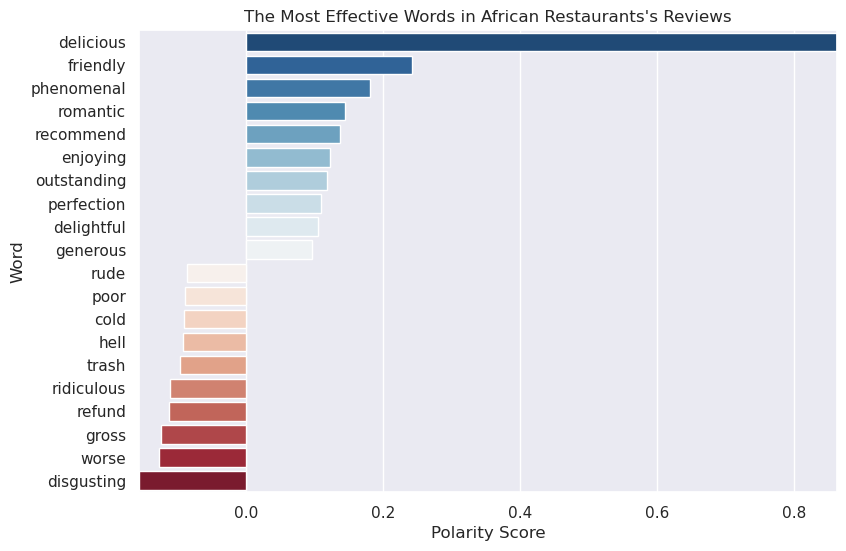

In [370]:
get_plot(african_df,'African')

In [ ]:
hawaiian_sum_df =get_polarity('Hawaiian')

In [373]:
hawaiian_sum_df.head(25)

StatementMeta(sparkpool, 20, 105, Finished, Available)

,word,coeff,freq,polarity
0,delicious,2.786398,5128.0,0.667881
1,fresh,1.549208,5426.0,0.392914
2,friendly,1.031693,4075.0,0.196511
3,recommend,0.923712,2343.0,0.101162
4,fun,2.360756,738.0,0.081436
5,attentive,2.588746,593.0,0.071755
6,stumbled,16.619485,83.0,0.064477
7,incredible,3.220786,378.0,0.056906
8,clean,0.818329,1431.0,0.054736
9,fast,0.913560,1242.0,0.053035


StatementMeta(sparkpool, 20, 104, Finished, Available)

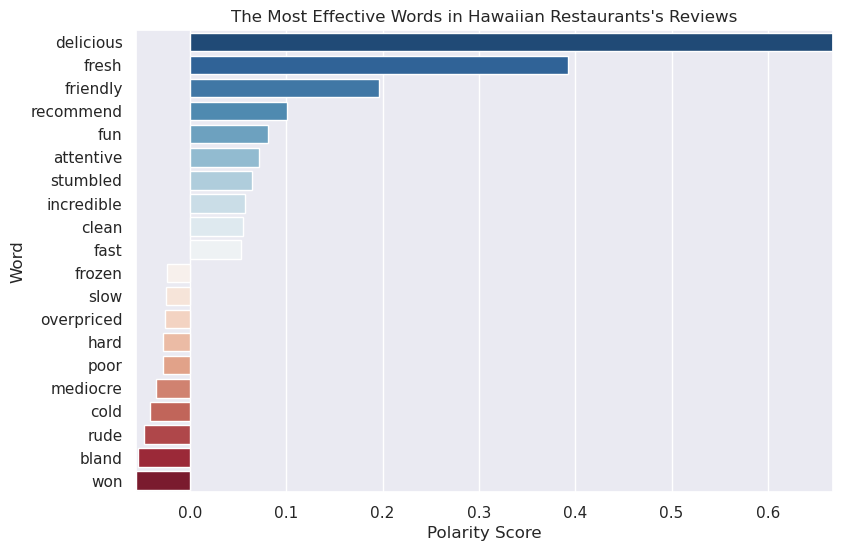

In [372]:
get_plot(hawaiian_sum_df,'Hawaiian')

In [ ]:
spanish_sum_df = get_polarity('Spanish')

In [378]:
spanish_sum_df.head(25)

StatementMeta(sparkpool, 20, 110, Finished, Available)

,word,coeff,freq,polarity
0,delicious,2.251690,9584.0,0.650770
1,friendly,1.132263,4214.0,0.143885
2,recommend,0.759141,4303.0,0.098507
3,outstanding,3.358494,914.0,0.092568
4,incredible,2.581753,1003.0,0.078089
5,fresh,0.728280,3432.0,0.075373
6,authentic,1.030783,2229.0,0.069287
7,downside,20.149373,113.0,0.068661
8,fun,1.564154,1326.0,0.062545
9,perfection,2.652211,683.0,0.054626


StatementMeta(sparkpool, 20, 111, Finished, Available)

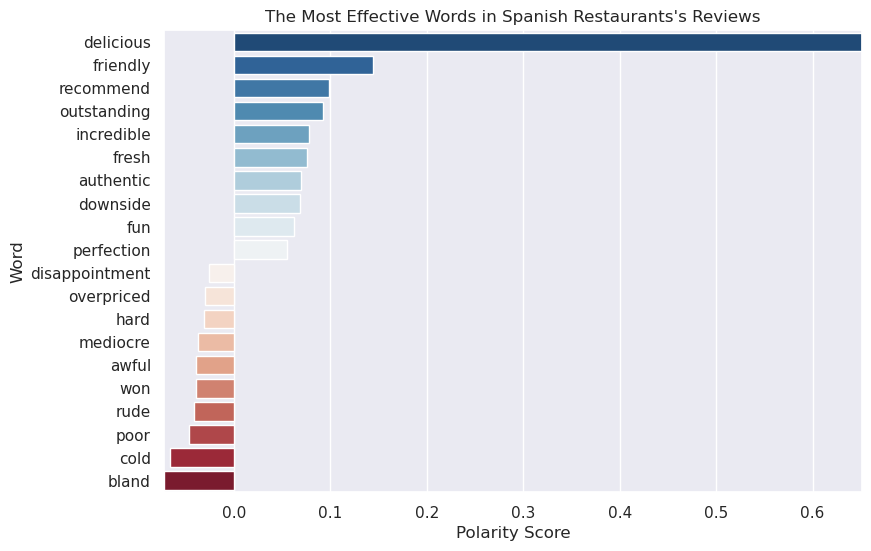

In [379]:
get_plot(spanish_sum_df,'Spanish')

In [ ]:
korean_sum_df = get_polarity('Korean')

In [99]:
korean_sum_df.head(25)

StatementMeta(sparkpool, 22, 55, Finished, Available)

,word,coeff,freq,polarity
0,delicious,2.289972,12006.0,0.568586
1,friendly,1.201455,7101.0,0.176439
2,fresh,0.745872,7548.0,0.116430
3,recommend,0.507327,5977.0,0.062710
4,hot,0.365422,7522.0,0.056845
5,tender,1.908919,1397.0,0.055151
6,fried,0.328889,8070.0,0.054890
7,attentive,1.132975,2114.0,0.049533
8,fun,1.239100,1920.0,0.049201
9,variety,1.044061,2066.0,0.044609


StatementMeta(sparkpool, 22, 56, Finished, Available)

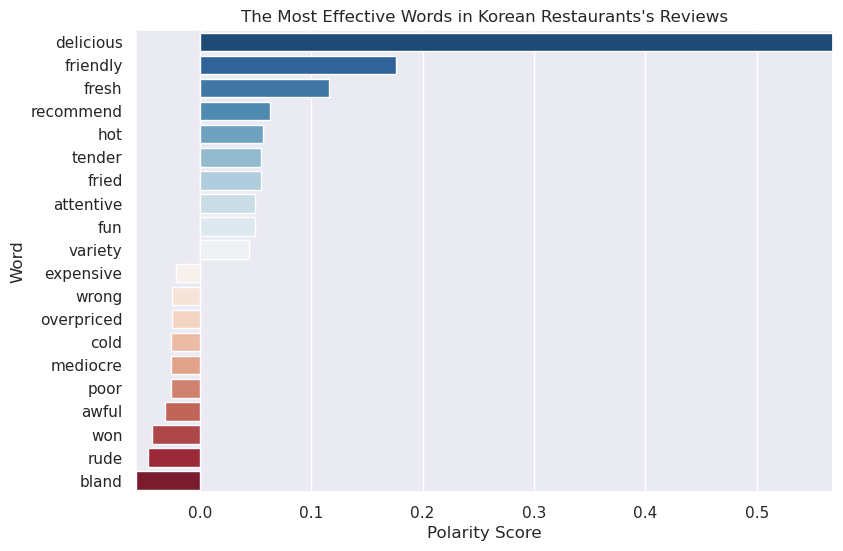

In [100]:
get_plot(korean_sum_df, 'Korean')

In [ ]:
greek_sum_df = get_polarity('Greek')

In [102]:
greek_sum_df.head(25)

StatementMeta(sparkpool, 22, 58, Finished, Available)

,word,coeff,freq,polarity
0,delicious,2.423420,16755.0,0.641065
1,friendly,1.215551,10755.0,0.206401
2,fresh,0.963883,12543.0,0.190877
3,recommend,0.803453,6514.0,0.082630
4,incredible,2.641458,1249.0,0.052088
5,reasonable,1.599453,1963.0,0.049570
6,perfection,3.102183,1003.0,0.049124
7,outstanding,2.080159,1348.0,0.044271
8,die,2.989318,917.0,0.043278
9,fast,0.655305,3900.0,0.040349


StatementMeta(sparkpool, 22, 59, Finished, Available)

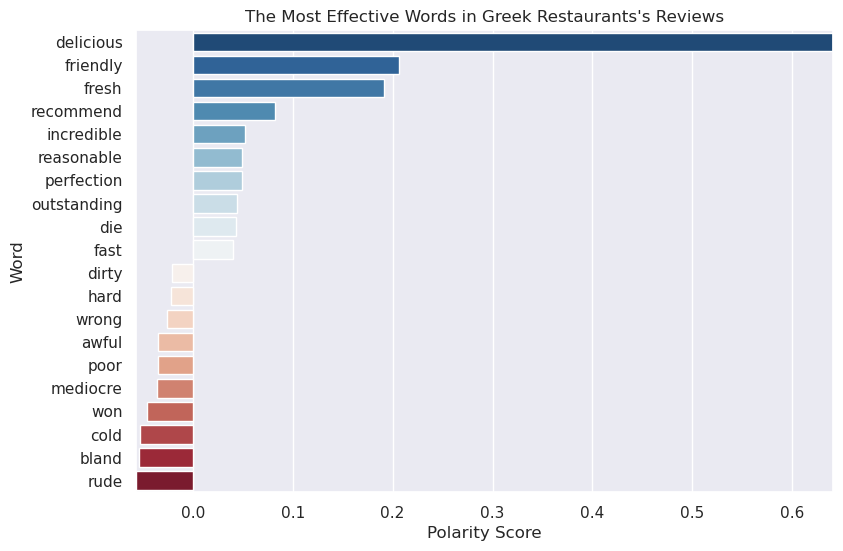

In [103]:
get_plot(greek_sum_df, 'Greek')

In [ ]:
indian_sum_df = get_polarity('Indian')

In [232]:
indian_sum_df.head(25)

StatementMeta(sparkpool, 43, 55, Finished, Available)

,word,coeff,freq,polarity
0,delicious,2.373168,18048.0,0.645345
1,friendly,1.568604,9270.0,0.219093
2,fresh,0.715899,8255.0,0.089044
3,recommend,0.660126,8074.0,0.080306
4,incredible,3.074074,1383.0,0.064058
5,attentive,1.260721,3071.0,0.058336
6,tender,1.463414,2218.0,0.048906
7,warmly,28.072268,107.0,0.045258
8,helpful,1.324291,2121.0,0.042321
9,outstanding,2.149837,1243.0,0.040263


StatementMeta(sparkpool, 43, 56, Finished, Available)

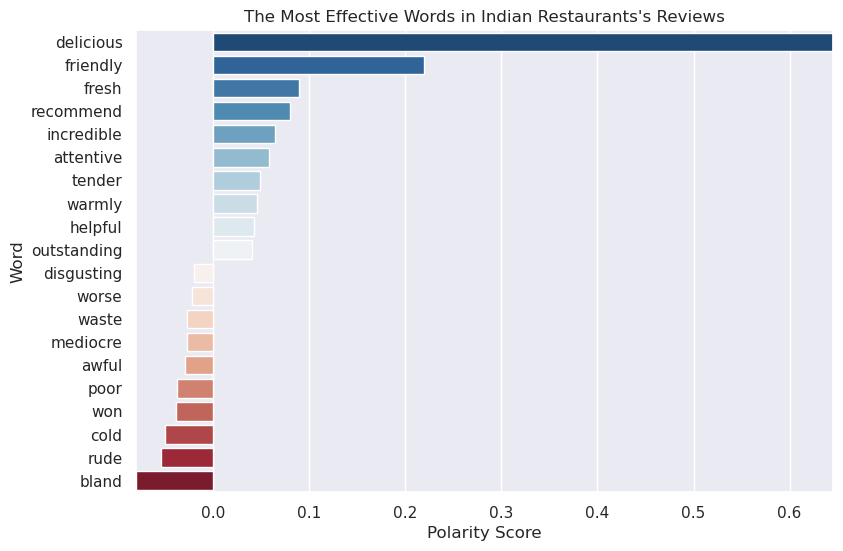

In [233]:
get_plot(indian_sum_df, 'Indian')

In [ ]:
french_sum_df = get_polarity('French')

In [285]:
french_sum_df.head(25)

StatementMeta(sparkpool, 44, 52, Finished, Available)

,word,coeff,freq,polarity
0,delicious,2.148989,12201.0,0.645856
1,friendly,0.974946,5115.0,0.122838
2,perfection,3.142347,1190.0,0.092110
3,fresh,0.735160,4749.0,0.085998
4,incredible,2.132209,1482.0,0.077837
5,die,3.028388,1039.0,0.077506
6,attentive,0.823183,2843.0,0.057647
7,outstanding,1.499137,1512.0,0.055834
8,recommend,0.443872,4910.0,0.053684
9,sweet,0.606360,3540.0,0.052874


StatementMeta(sparkpool, 44, 53, Finished, Available)

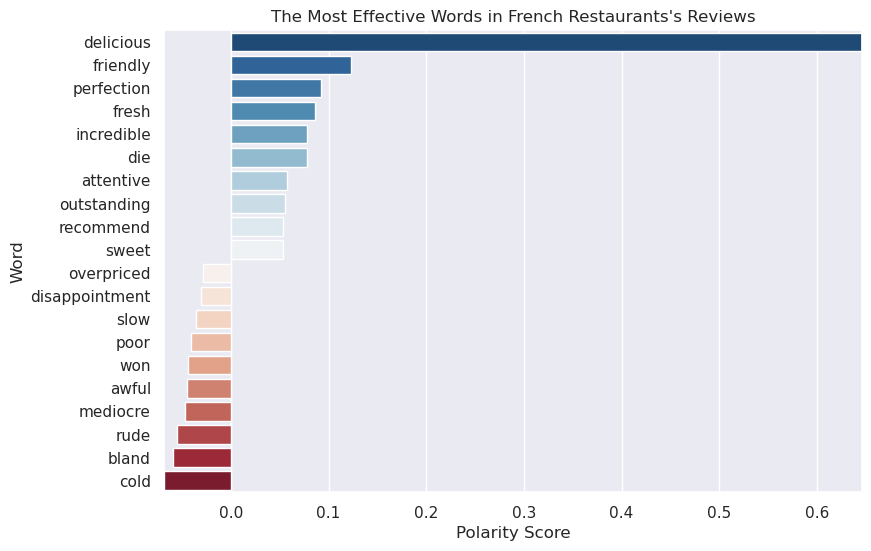

In [286]:
get_plot(french_sum_df, 'French')

In [ ]:
thai_sum_df = get_polarity('Thai')

In [288]:
thai_sum_df.head(25)

StatementMeta(sparkpool, 44, 55, Finished, Available)

,word,coeff,freq,polarity
0,delicious,2.362853,12806.0,0.609600
1,friendly,1.163774,7383.0,0.173100
2,fresh,0.985925,8337.0,0.165595
3,recommend,0.721739,5781.0,0.084058
4,reasonable,2.337136,1760.0,0.082869
5,hot,0.445776,5991.0,0.053803
6,heavenly,25.915807,101.0,0.052733
7,outstanding,2.632864,845.0,0.044821
8,incredible,2.765889,800.0,0.044578
9,attentive,0.993587,2089.0,0.041816


StatementMeta(sparkpool, 44, 56, Finished, Available)

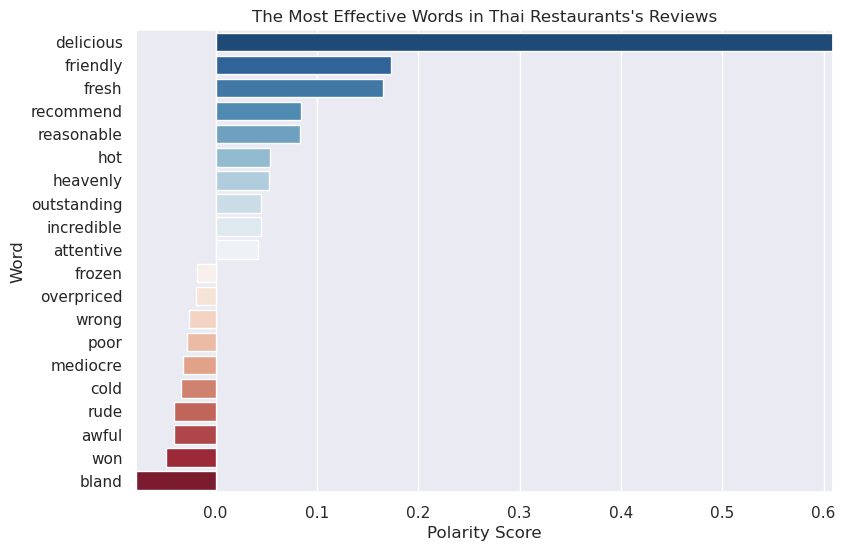

In [289]:
get_plot(thai_sum_df, 'Thai')